[View in Colaboratory](https://colab.research.google.com/github/masakiaota/blog/blob/vae/seq_vae_MNIST.ipynb)

====================preparating the data...====================
====================summary of this model====================
reconstruction Tensor("Mean_2:0", shape=(), dtype=float32) kl Tensor("mul_3:0", shape=(?,), dtype=float32)
seq_vaeの構成
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 28, 28)       0                                            
__________________________________________________________________________________________________
cu_dnngru_3 (CuDNNGRU)          (None, 40)           8400        input_2[0][0]                    
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 3)            123         cu_dnngru_3[0][0]                
_______________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:143: UserWarning: Output "time_distributed_2" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "time_distributed_2" during training.


Train on 54000 samples, validate on 6000 samples
Epoch 1/100
54000/54000 [==============================] - 24s 443us/step - loss: 0.3067 - val_loss: 0.2820
Epoch 2/100
54000/54000 [==============================] - 24s 446us/step - loss: 0.2669 - val_loss: 0.2556
Epoch 3/100
54000/54000 [==============================] - 24s 438us/step - loss: 0.2546 - val_loss: 0.2528
Epoch 4/100
54000/54000 [==============================] - 23s 420us/step - loss: 0.2521 - val_loss: 0.2505
Epoch 5/100
54000/54000 [==============================] - 23s 435us/step - loss: 0.2506 - val_loss: 0.2485
Epoch 6/100
54000/54000 [==============================] - 23s 422us/step - loss: 0.2473 - val_loss: 0.2452
Epoch 7/100
54000/54000 [==============================] - 24s 436us/step - loss: 0.2418 - val_loss: 0.2387
Epoch 8/100
54000/54000 [==============================] - 24s 435us/step - loss: 0.2377 - val_loss: 0.2358
Epoch 9/100
54000/54000 [==============================] - 23s 432us/step - loss: 0.235

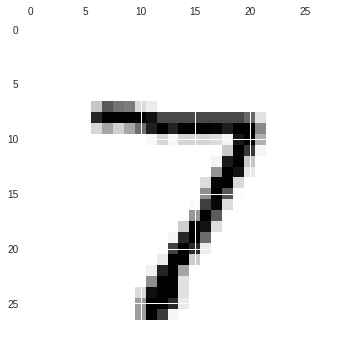

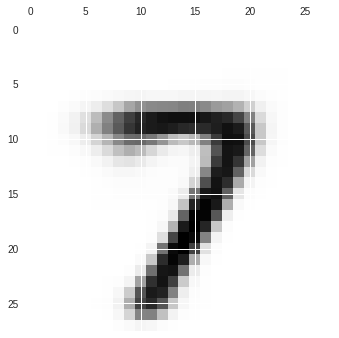

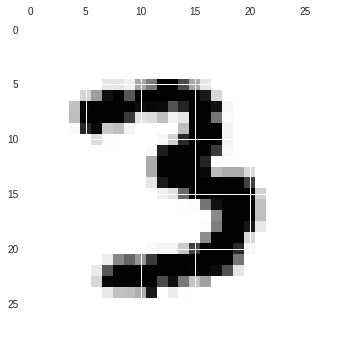

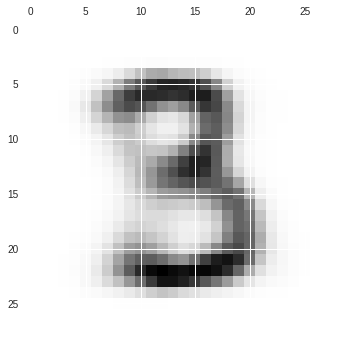

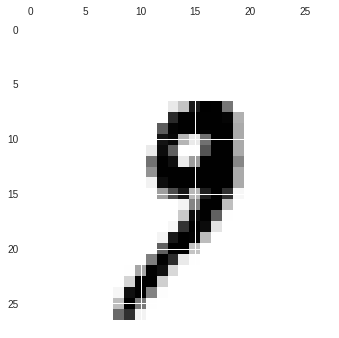

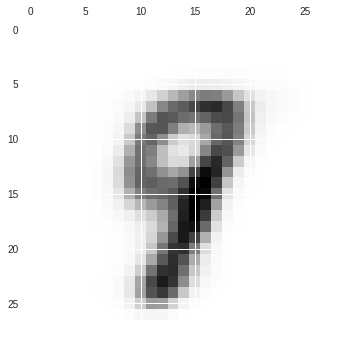

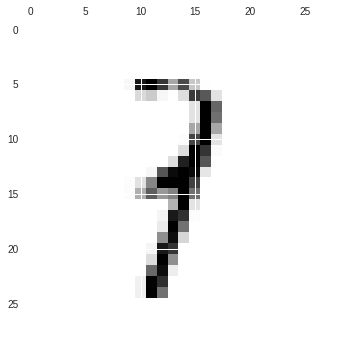

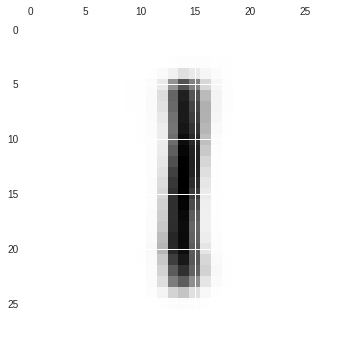

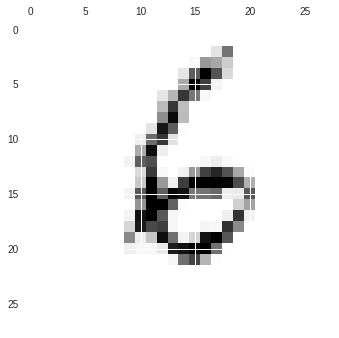

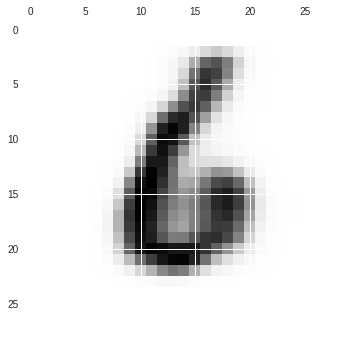

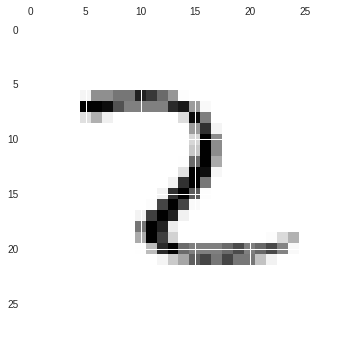

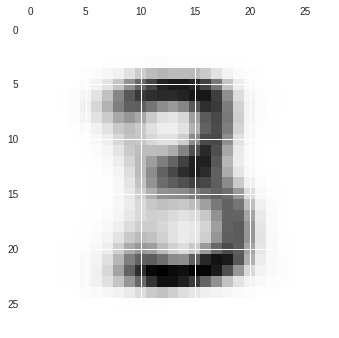

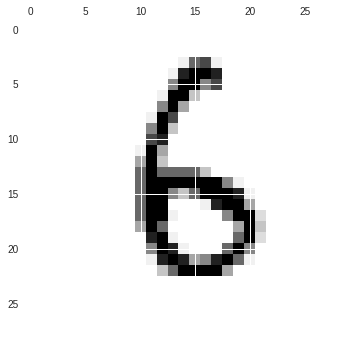

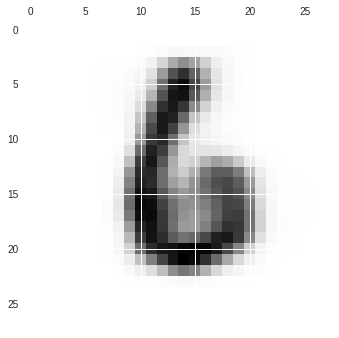

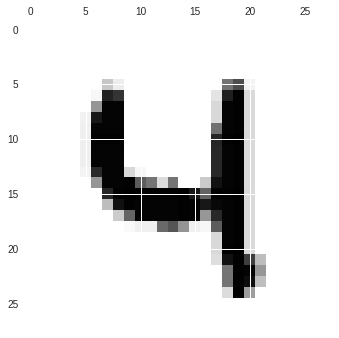

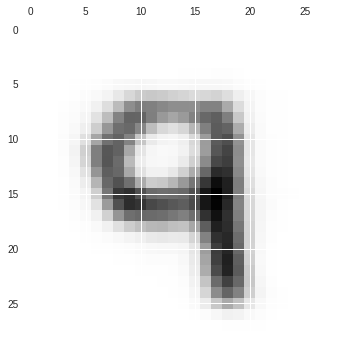

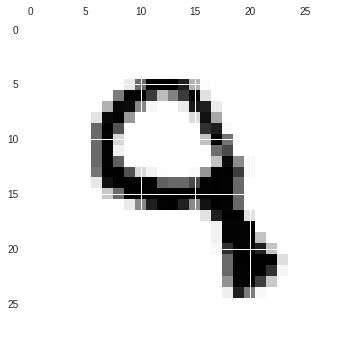

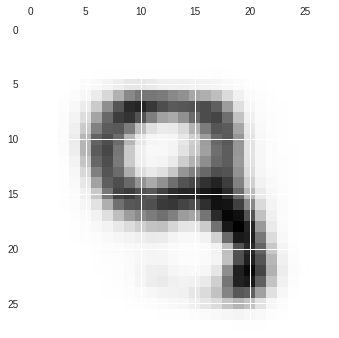

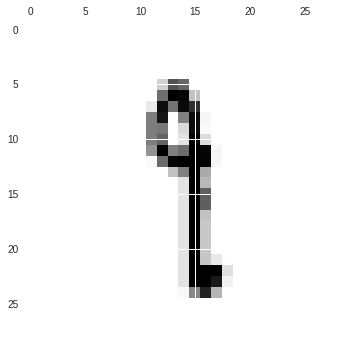

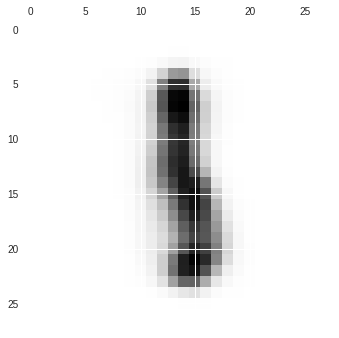

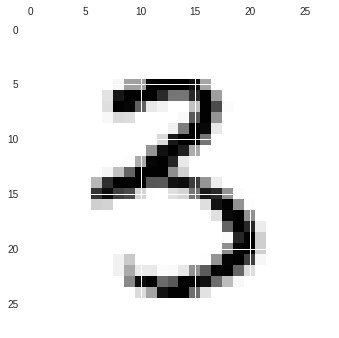

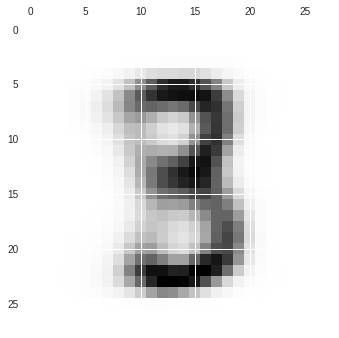

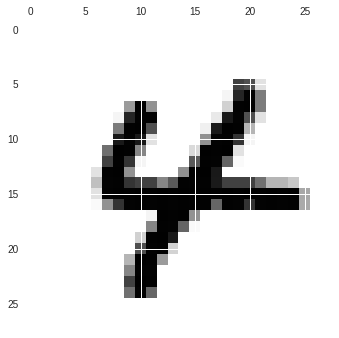

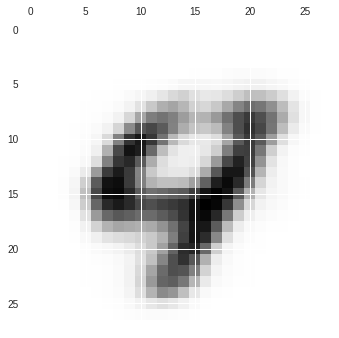

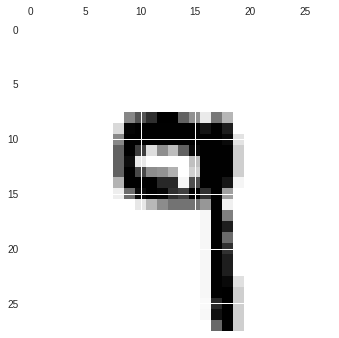

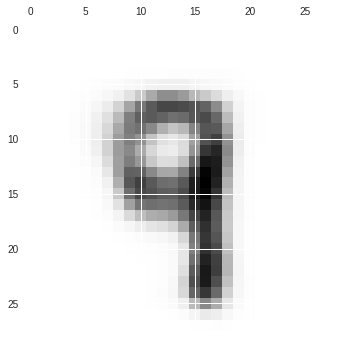

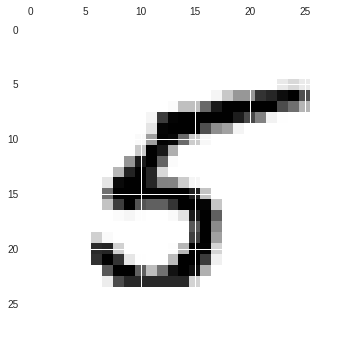

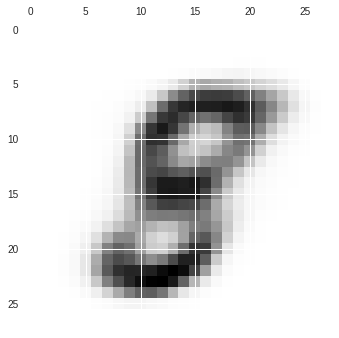

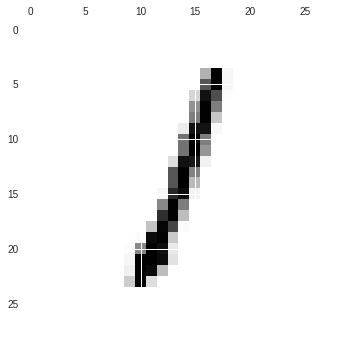

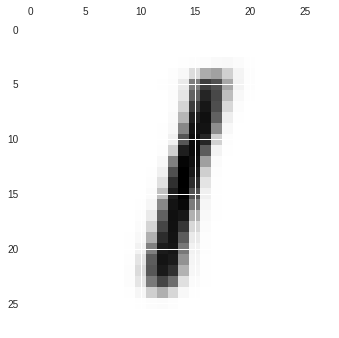

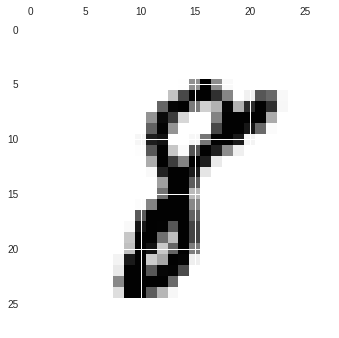

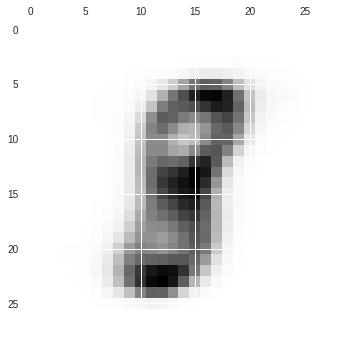

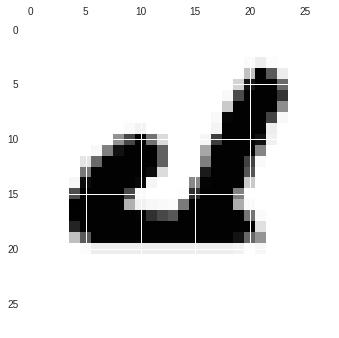

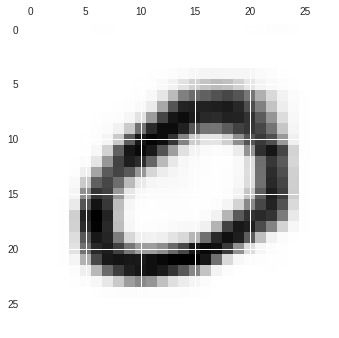

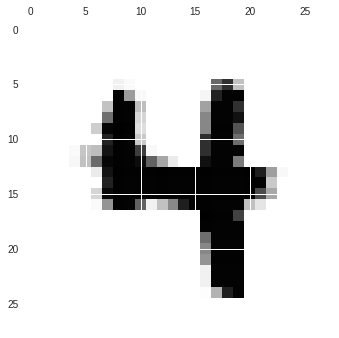

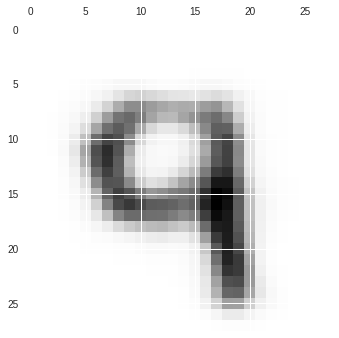

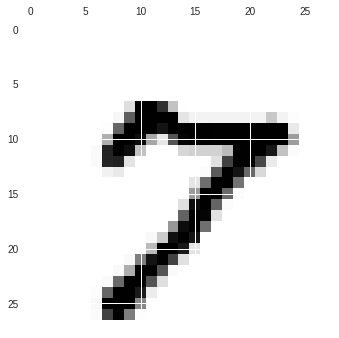

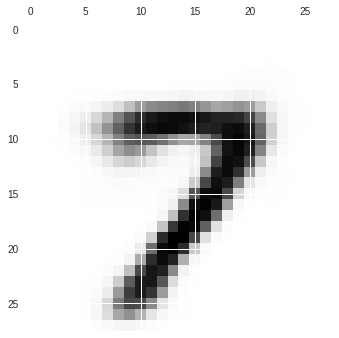

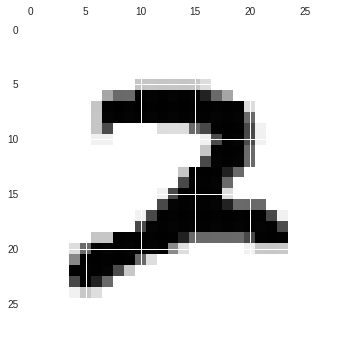

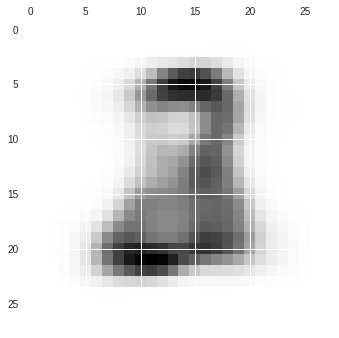

'\n121ぐらい\n'

In [4]:
"""
gruを用いたvae

vaeで時系列に見立てたMNISTを生成
"""
import math
import os
import numpy as np
from keras.layers import Input, InputLayer, Dense, RepeatVector, Lambda, TimeDistributed
# from keras.layers import GRU
from keras.layers import CuDNNGRU as GRU  # GPU用
from keras.models import Model, Sequential
from keras.callbacks import TensorBoard, EarlyStopping
from keras.optimizers import adam
from keras import backend as K
# データの準備


def prepare_data():
    """
    戻り値
      規格化された
      x_train, x_test
    """
    from keras.datasets import mnist
    (x_train, _), (x_test, _) = mnist.load_data()
    x_train, x_test = x_train/255, x_test/255
    # >>> x_train.shape, x_test.shape
    # ((60000, 28, 28), (10000, 28, 28))
    # これを(None, NUM_TIMESTEPS, NUM_INPUT_DIM)と対応させる
    global NUM_TIMESTEPS, NUM_INPUT_DIM
    _, NUM_TIMESTEPS, NUM_INPUT_DIM = x_train.shape
    return x_train, x_test


def seq_vae():
    """
    入力(input)
    ↓
    GRU(encoder)
    ↓
    内部状態
    ↓   ↓
    mean, log_var
    ↓
    zをサンプリング(ここまでencoder)
    ↓（このzを復元された内部状態だとして）
    GRU(decoder)
    ↓
    全結合層(出力)


    戻り値
     model
    """
    LATENT_DIM = 40
    CODING_DIM=3

    def sampling(args):
        """
        z_mean, z_log_var=argsからzをサンプリングする関数
        戻り値
            z (tf.tensor):サンプリングされた潜在変数
        """
        z_mean, z_log_var = args
        batch = K.shape(z_mean)[0]
        dim = K.int_shape(z_mean)[1]
        # by default, random_normal has mean=0 and std=1.0
        epsilon = K.random_normal(shape=(batch, dim))
        # K.exp(0.5 * z_log_var)が分散に標準偏差になっている
        # いきなり標準偏差を求めてしまっても構わないが、負を許容してしまうのでこのようなトリックを用いている
        return z_mean + K.exp(0.5 * z_log_var) * epsilon

    # encoderの定義
    inputs = Input(shape=(NUM_TIMESTEPS, NUM_INPUT_DIM))
    # (None, NUM_TIMESTEPS,NUM_INPUT_DIM)
    x = GRU(LATENT_DIM)(inputs)
    # (None, CODING_DIM)
    z_mean = Dense(CODING_DIM, name='z_mean')(x)  # z_meanを出力
    # (None, CODING_DIM)
    z_log_var = Dense(CODING_DIM, name='z_log_var')(x)  # z_sigmaを出力
    # (None, LATENT_DIM)

    # use reparameterization trick to push the sampling out as input
    # note that "output_shape" isn't necessary with the TensorFlow backend
    z = Lambda(sampling, output_shape=(CODING_DIM,), name='z')(
        [z_mean, z_log_var])  # 2つの変数を受け取ってランダムにサンプリング
    # (None, CODING_DIM)
    encoder = Model(inputs, [z_mean, z_log_var, z], name="encoder")
    # encoder部分は入力を受けて平均、分散、そこからランダムサンプリングしたものの3つを返す

    # decoderの定義
    latent_inputs = RepeatVector(
        NUM_TIMESTEPS)(z)
    # (None, NUM_TIMESTEPS, CODING_DIM)
    x = GRU(LATENT_DIM, return_sequences=True)(latent_inputs)
    # (None, NUM_TIMESTEPS, LATENT_DIM)
    outputs = TimeDistributed(
        Dense(NUM_INPUT_DIM, activation='sigmoid'))(x)
    # (None, NUM_TIMESTEPS, NUM_INPUT_DIM)

    # instantiate decoder model
    # decoder = Model(z, outputs, name='decoder')
    # print("decoderの構成")
    # decoder.summary()

    # デコーダーとエンコーダーの結合
    # encoderの出力の3つめ、つまりzを入力として、decoderを実行する
    vae = Model(inputs, outputs, name='seq_vae')

    # 損失関数をこのモデルに加える
    def loss(inputs, outputs):
        """
        損失関数の定義
        """
        from keras.losses import binary_crossentropy
        z_mean, z_log_var, _ = encoder(inputs)
        reconstruction_loss = binary_crossentropy(
            K.flatten(inputs), K.flatten(outputs))
#         reconstruction_loss *= NUM_INPUT_DIM*NUM_TIMESTEPS
        kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
        kl_loss = K.sum(kl_loss, axis=-1)
        kl_loss *= -0.5
        
        lam = 0.01
        print("reconstruction",reconstruction_loss,"kl",kl_loss)
        return K.mean((1-lam)*reconstruction_loss + lam*kl_loss)#正規分布っ

    vae.add_loss(loss(inputs, outputs))
    print("seq_vaeの構成")
    vae.summary()
    return vae


if __name__ == "__main__":

    print("="*20+"preparating the data..."+"="*20)

    x_train, x_test = prepare_data()
    print("="*20+"summary of this model"+"="*20)
    seq_vae = seq_vae()

    seq_vae.compile(optimizer="nadam")#adam(lr=0.005))
    # 学習
    seq_vae.fit(x_train,
                epochs=100,
                batch_size=64,
                shuffle=True,
                validation_split=0.1,
                callbacks=[TensorBoard(log_dir="./MNIST_gru_vae/"), EarlyStopping(patience=3)])

    seq_vae.save('./MNIST_gru_vae/MNIST_gru_vae.h5')
    encoder=K.function([seq_vae.input],[seq_vae.get_layer("z_mean").output])
    decoder=K.function([seq_vae.get_layer("z").output],[seq_vae.layers[-1].output])
    # 推論
    x_pred = seq_vae.predict(x_test)

    import matplotlib.pyplot as plt
    # データをプロット
    for true, pred in zip(x_test[::500], x_pred[::500]):
        plt.matshow(true)

        plt.matshow(pred)
        plt.show()

"""
121ぐらい
"""


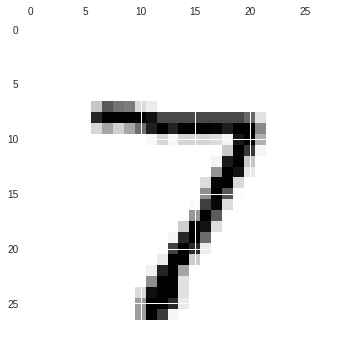

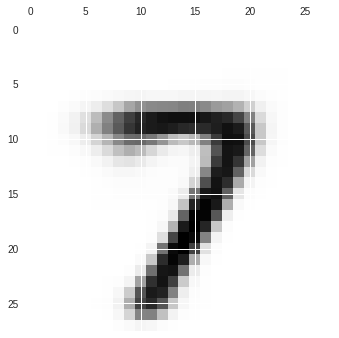

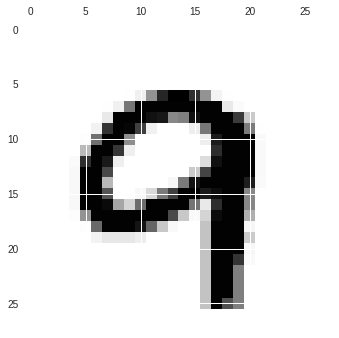

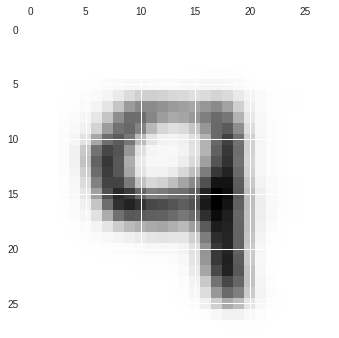

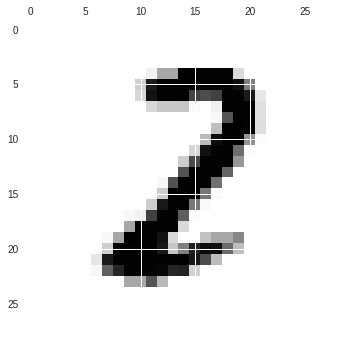

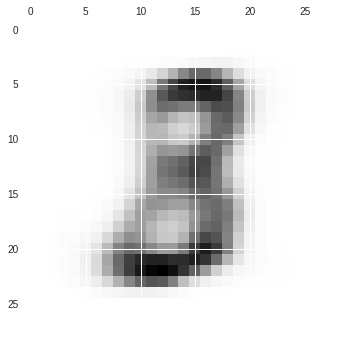

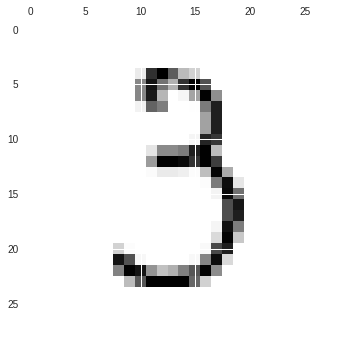

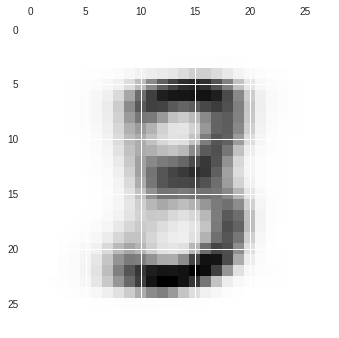

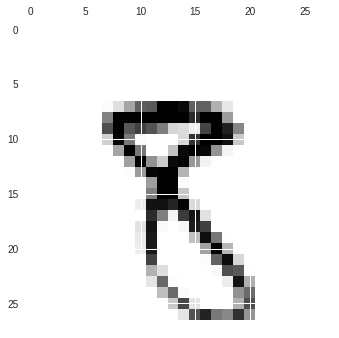

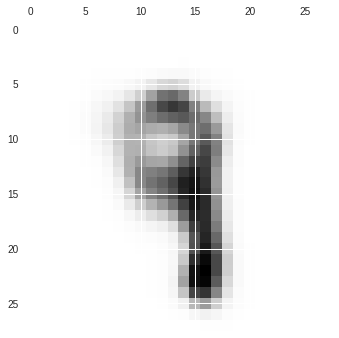

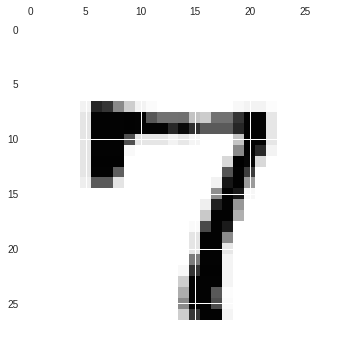

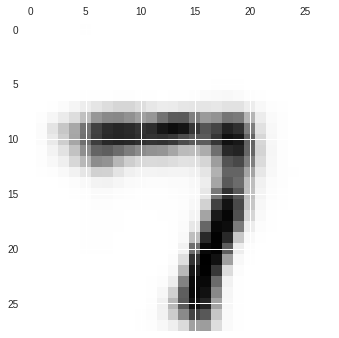

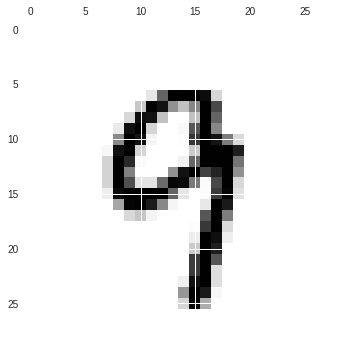

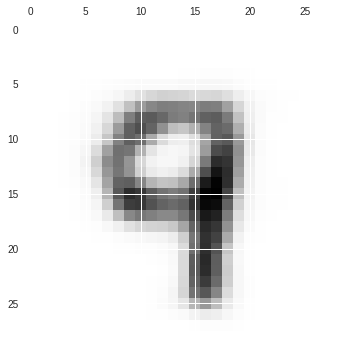

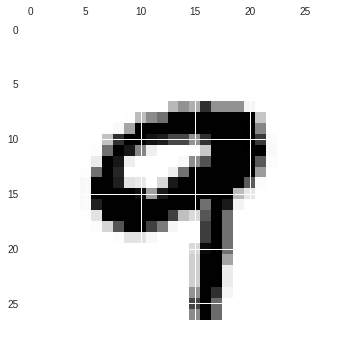

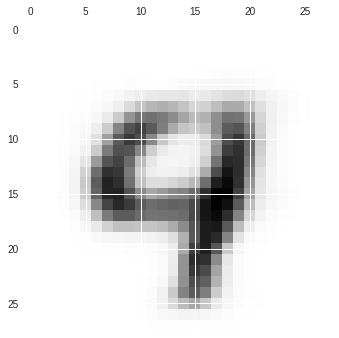

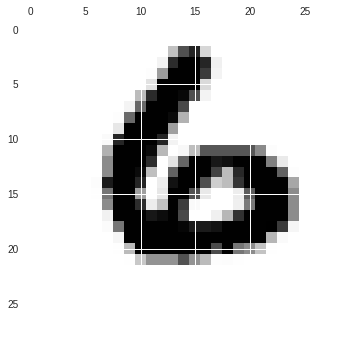

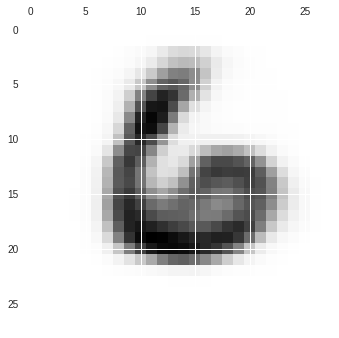

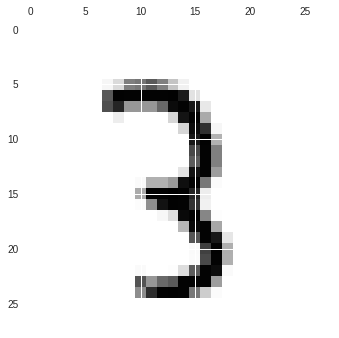

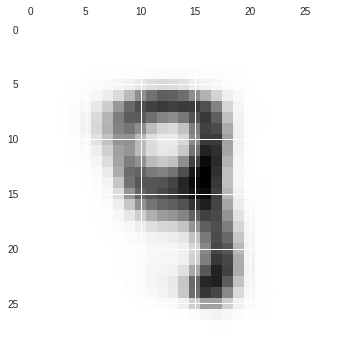

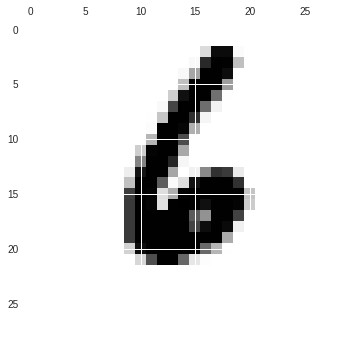

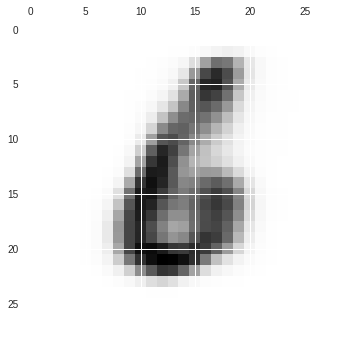

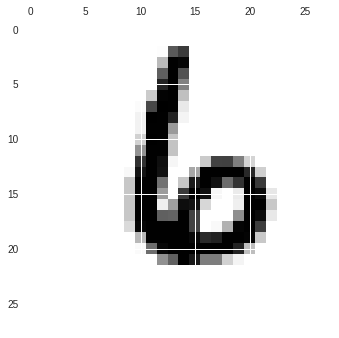

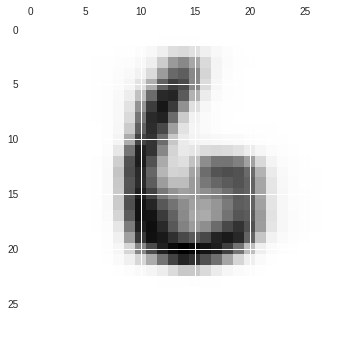

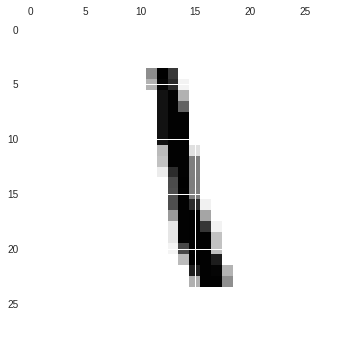

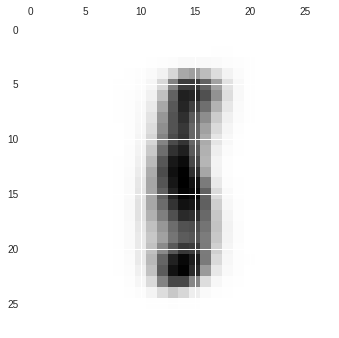

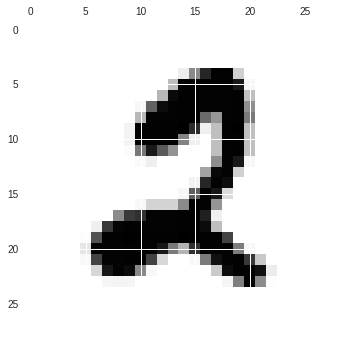

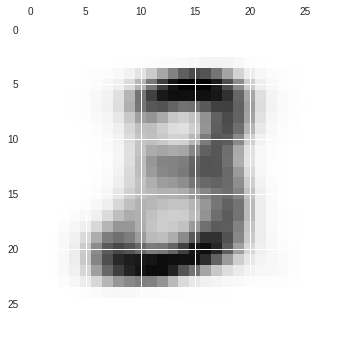

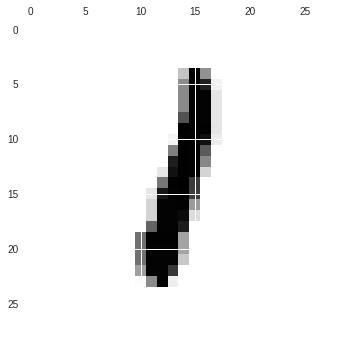

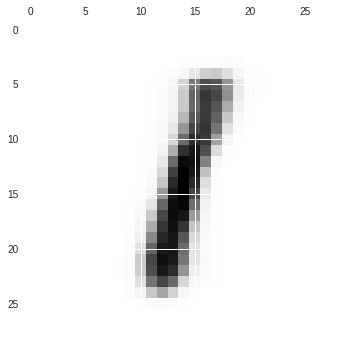

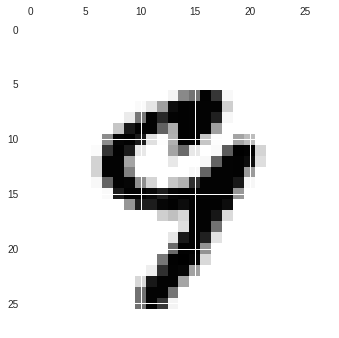

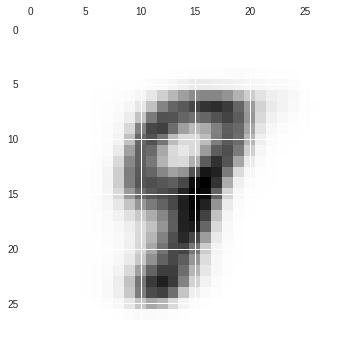

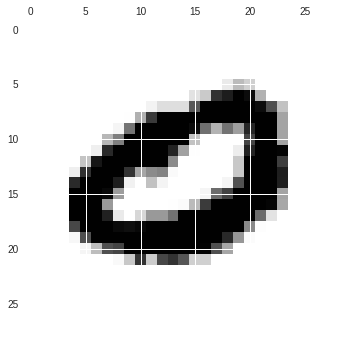

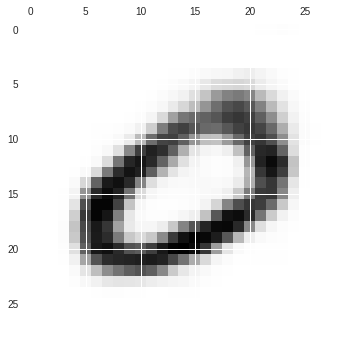

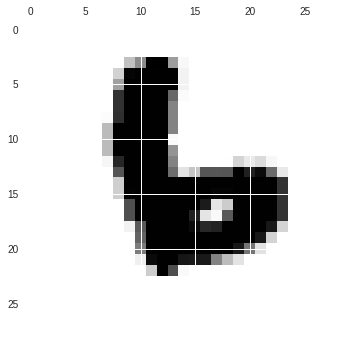

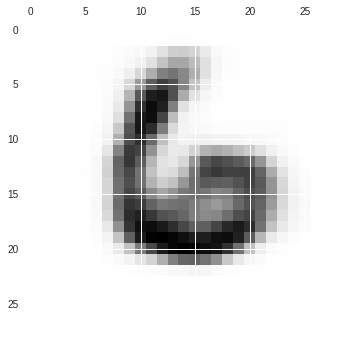

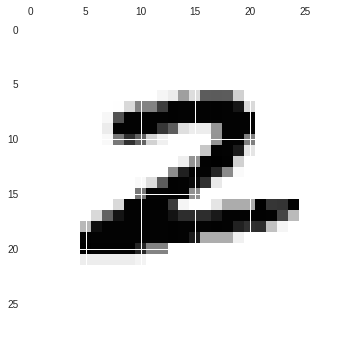

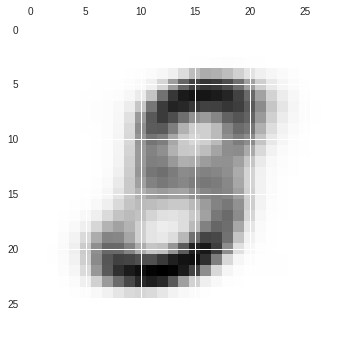

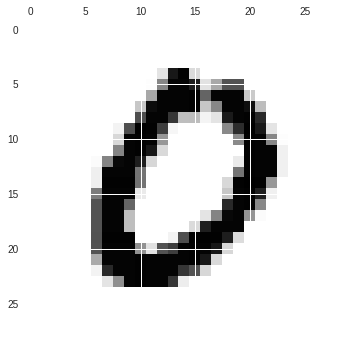

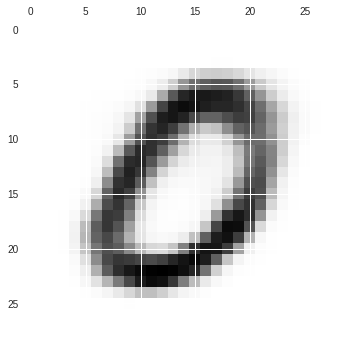

In [5]:
    for true, pred in zip(x_test[::501], x_pred[::501]):
        plt.matshow(true)

        plt.matshow(pred)
        plt.show()

In [7]:
coded=encoder([x_test])[0]
coded.max(), coded.min(),coded.mean()

(3.0729775, -2.8906302, -0.022797382)

3.0744972093399774


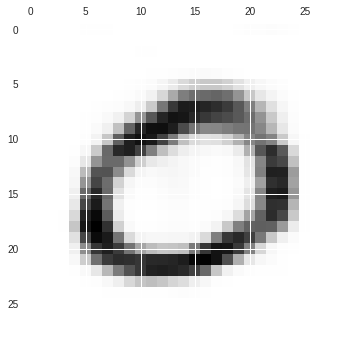

1.6852912651423153


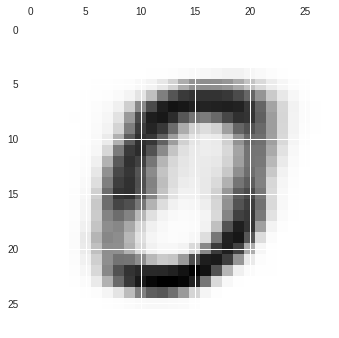

1.2887464643997466


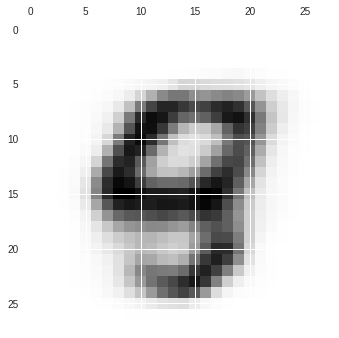

1.1476213301477745


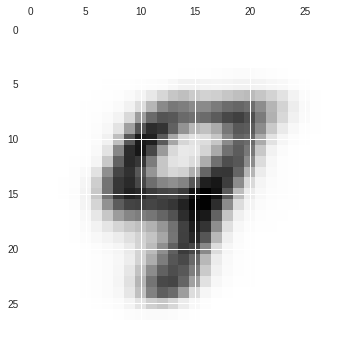

1.781031808459905


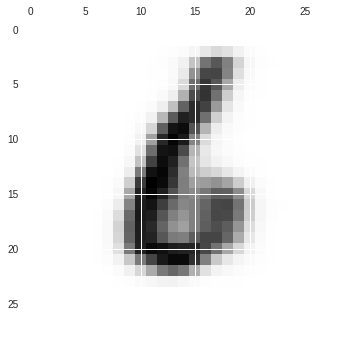

1.5959688768403972


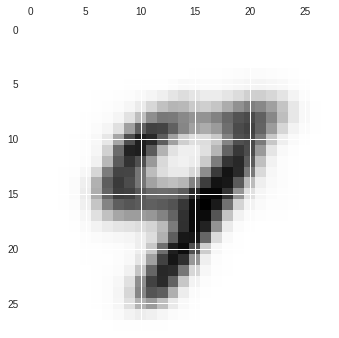

1.9200962398409414


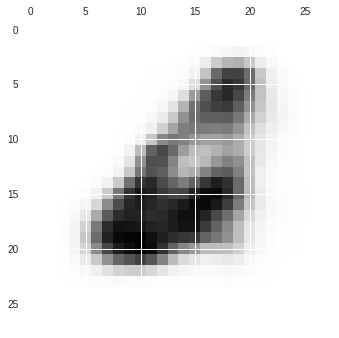

1.7876473206963233


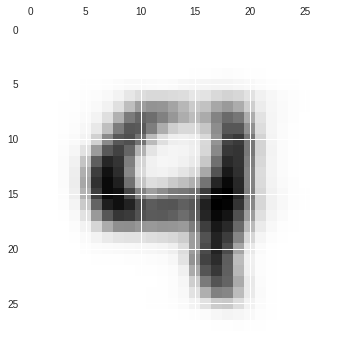

1.343928871704931


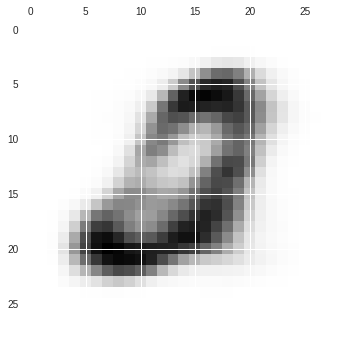

1.3590512358503537


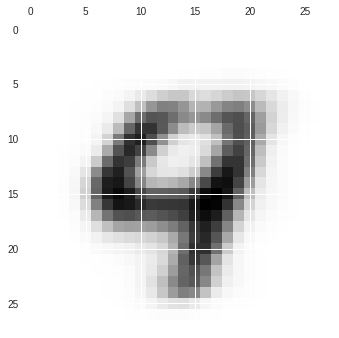

1.0695462728313812


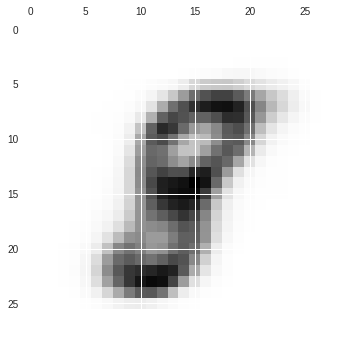

1.7206210963284634


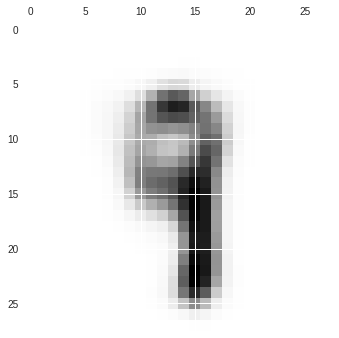

2.302882453420673


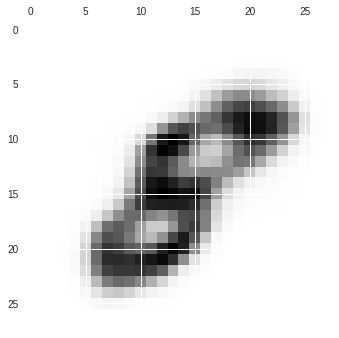

2.71623546044082


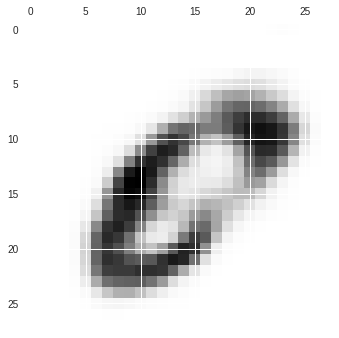

1.2089152229557176


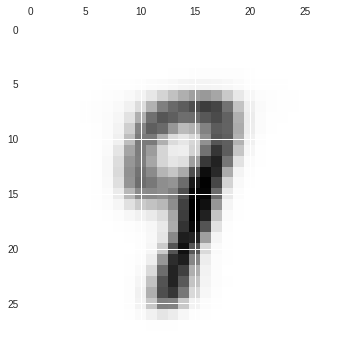

1.6109037563185442


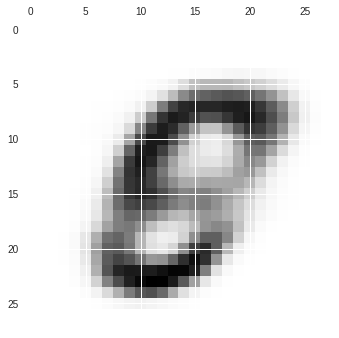

0.5752668802346963


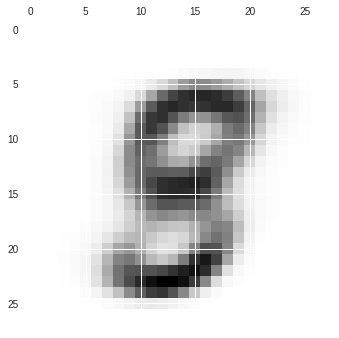

2.321389254297735


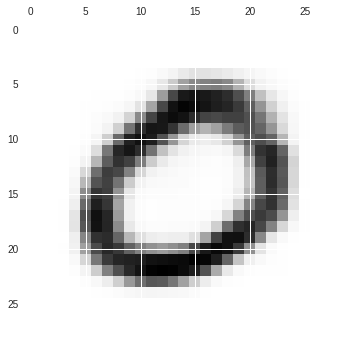

1.6226410358324304


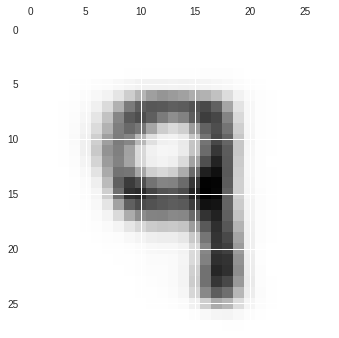

1.3693089356949626


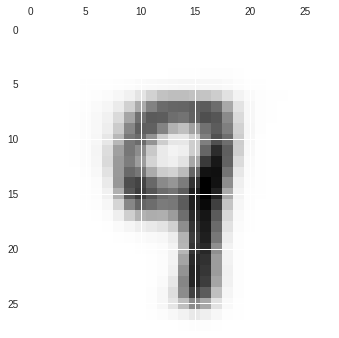

1.2355934492279086


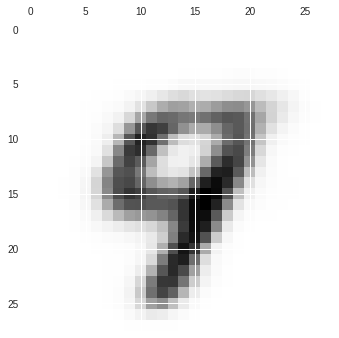

1.2363933602995967


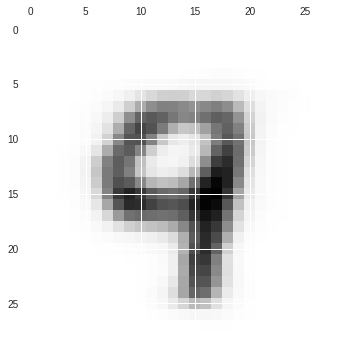

1.5211071891807169


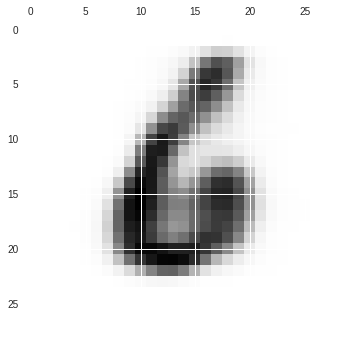

1.8264651936380736


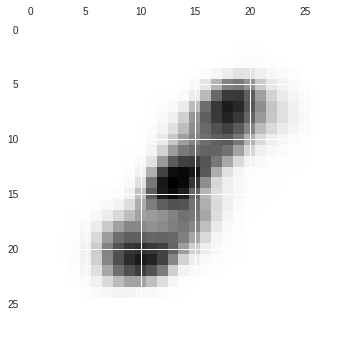

1.0771117589994985


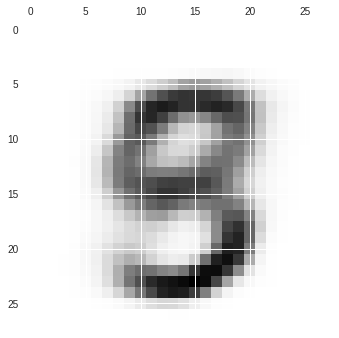

1.0924889649272878


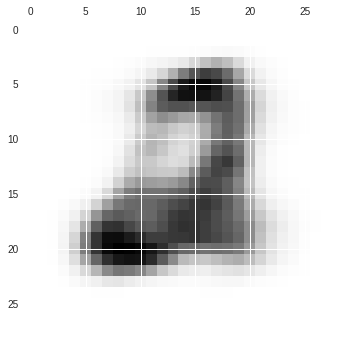

1.702120125826371


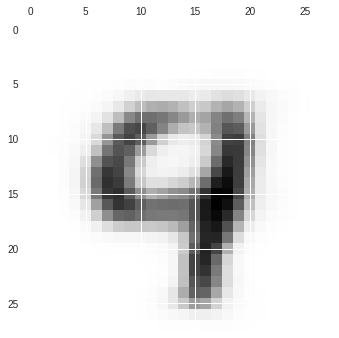

1.8538157209314907


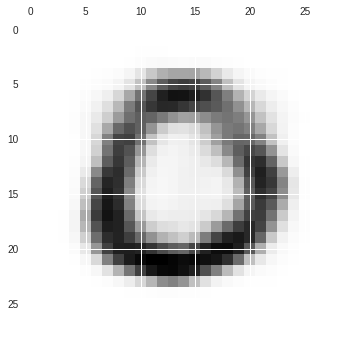

1.905899333943818


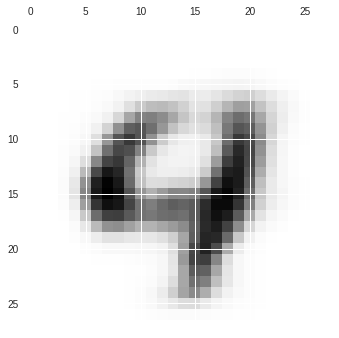

1.1755871838990297


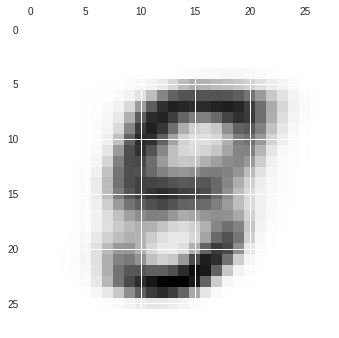

1.9766308450180068


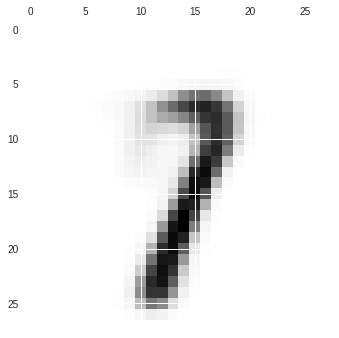

1.4350416941670914


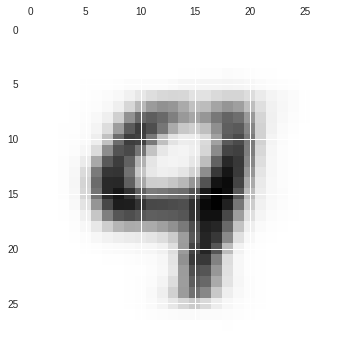

0.9655624718164085


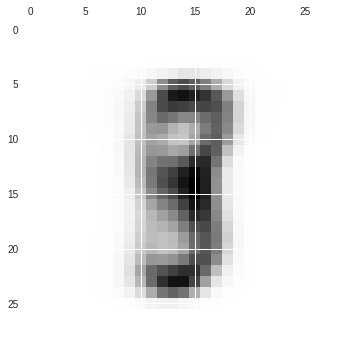

2.418352597000957


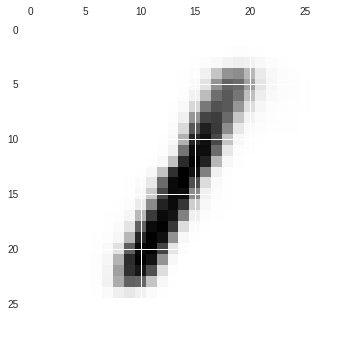

0.9821366858042049


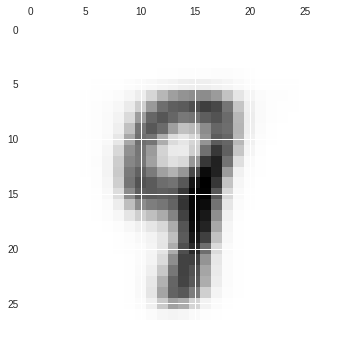

0.5438938628234374


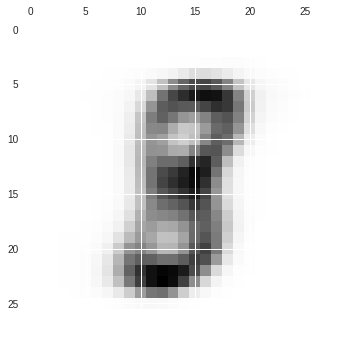

2.1128992139639147


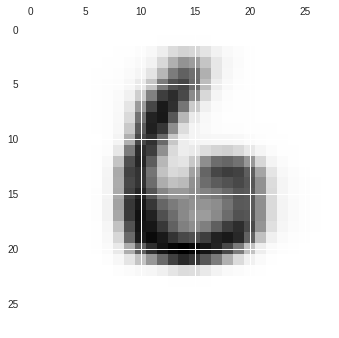

1.145719479352709


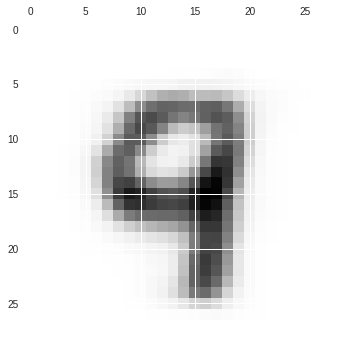

0.9312910449597998


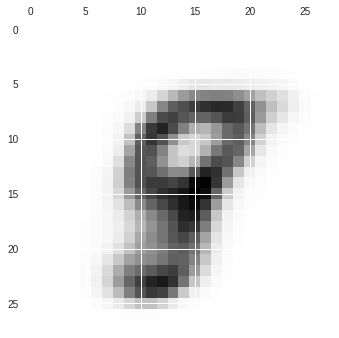

0.6592870999531235


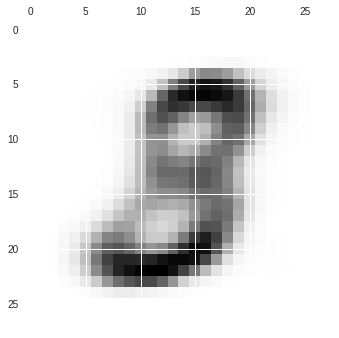

2.073099176667246


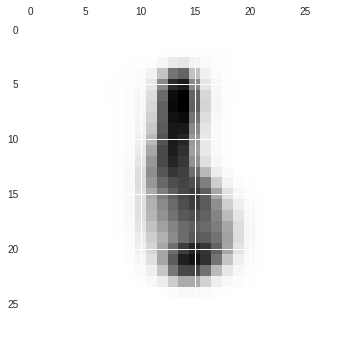

2.0285142872900566


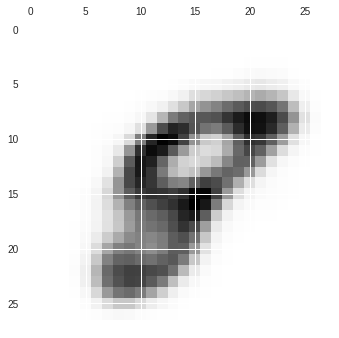

0.5192701653159656


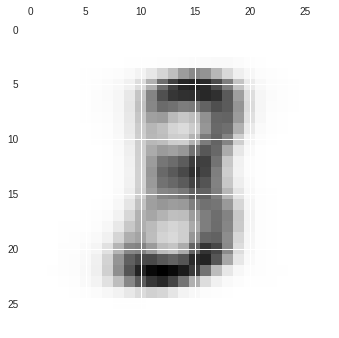

1.9051655554896605


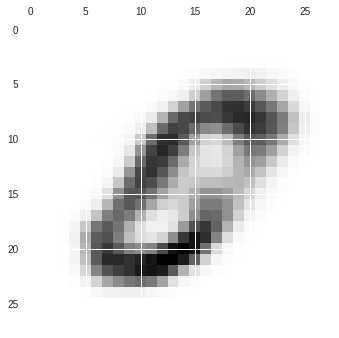

1.9896476735221593


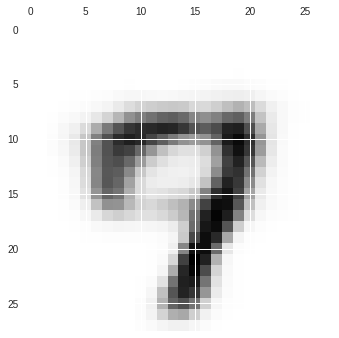

0.4495688024708518


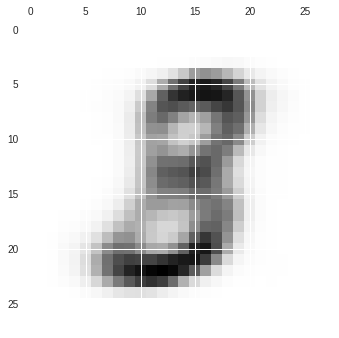

1.8142578389224355


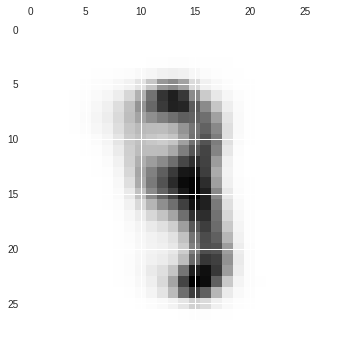

1.5036825870311117


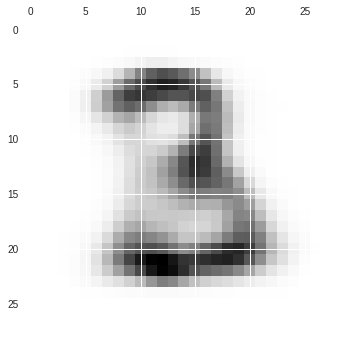

2.09599533093701


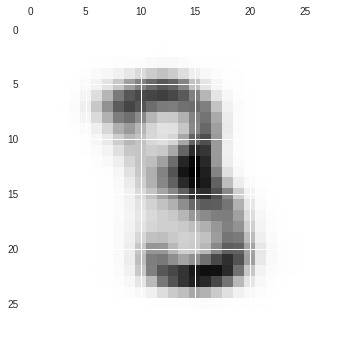

1.3295400836038551


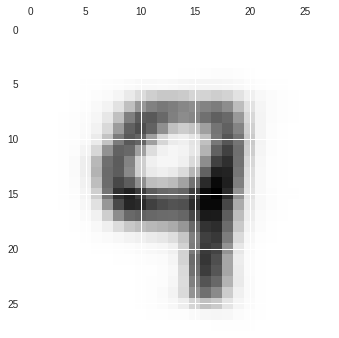

1.7458388725543357


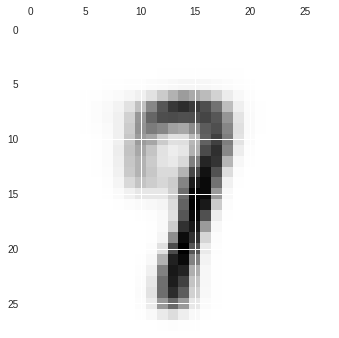

2.2323444667963703


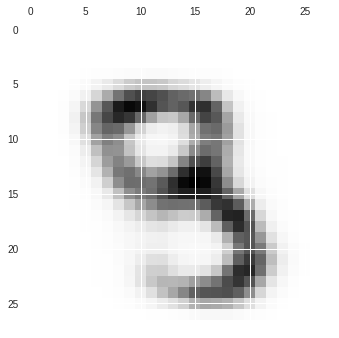

3.333627578143682


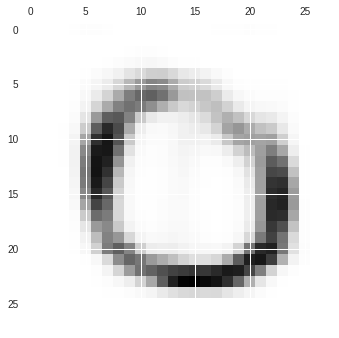

1.3322855573224752


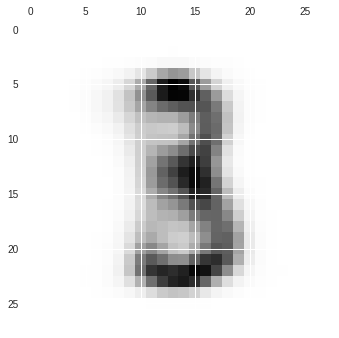

1.3456342121995661


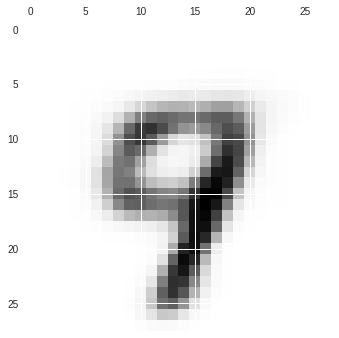

1.3687676303499137


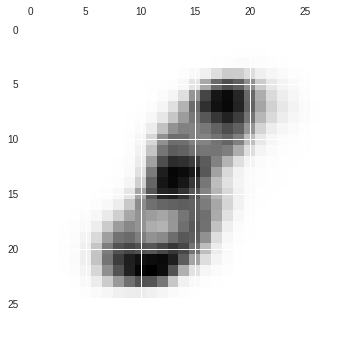

0.8879611605268515


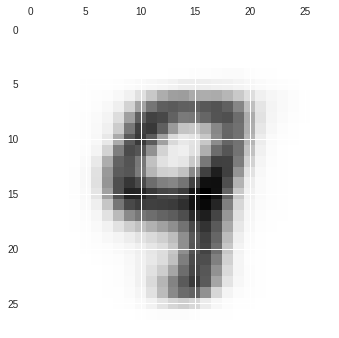

1.8365058663550569


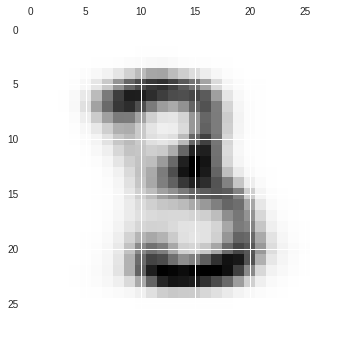

1.4238246464824313


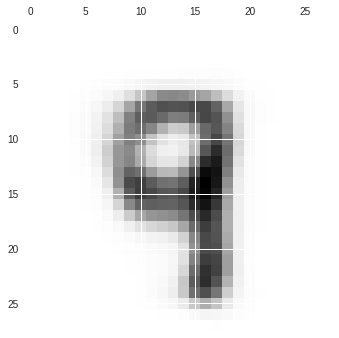

1.5332293776718662


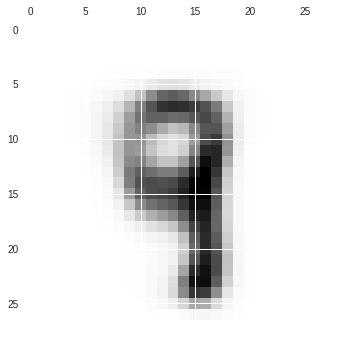

1.877776129555288


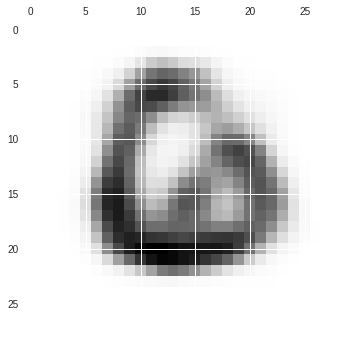

1.9186949855626814


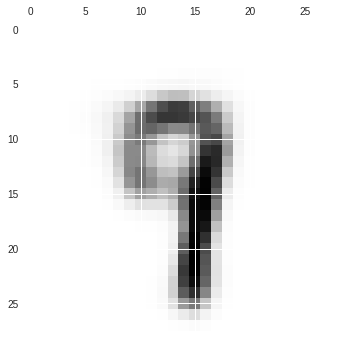

2.6592845256341917


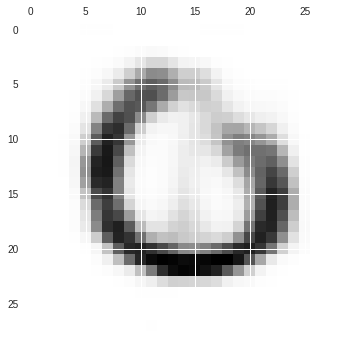

0.920667147627089


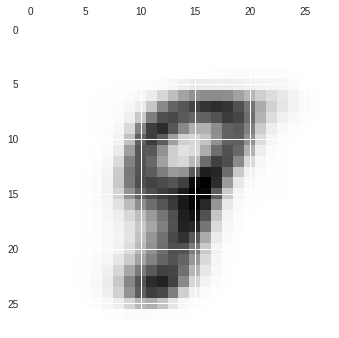

1.2088866382871482


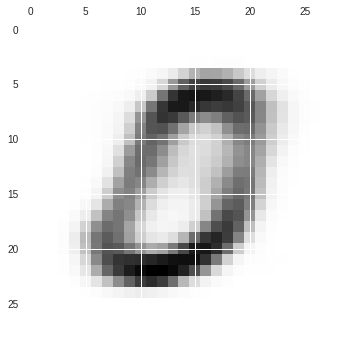

2.28614942135465


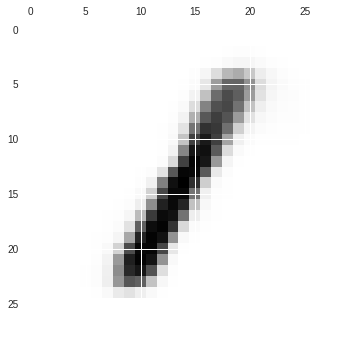

0.48262983311310875


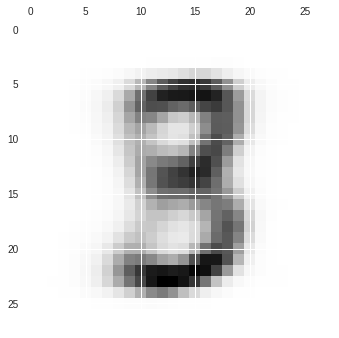

1.2220472079202598


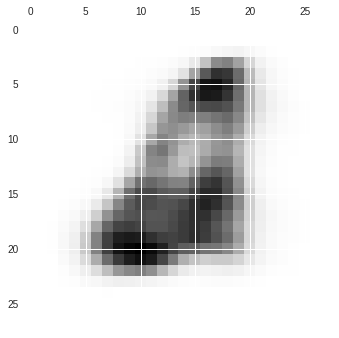

1.8420959514649062


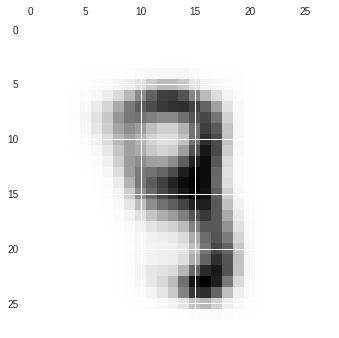

1.3907290077466243


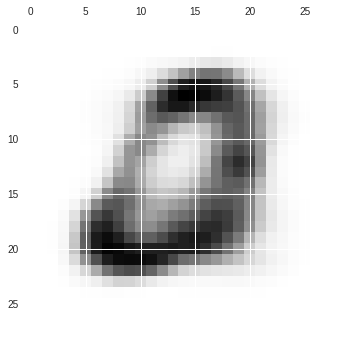

1.302818876445447


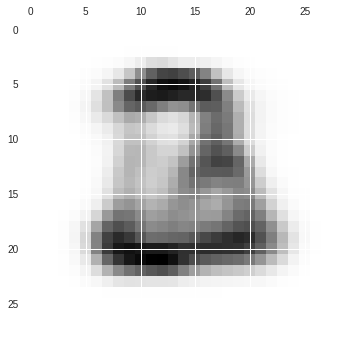

1.152789132864984


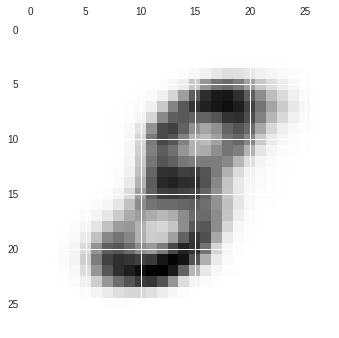

0.9446952505964918


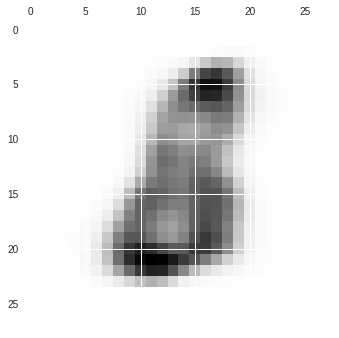

2.998226658696674


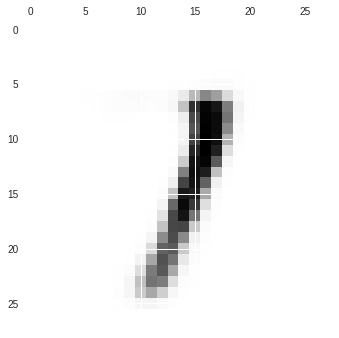

1.8539012860201225


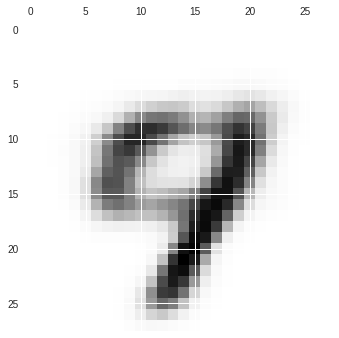

1.6359791316508445


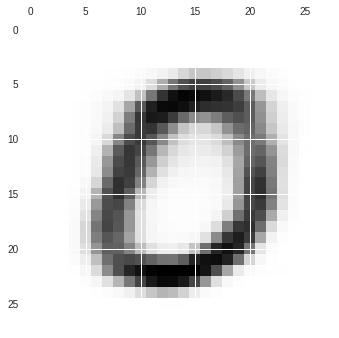

1.6261333941871507


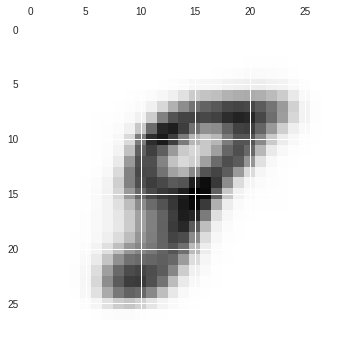

1.6372106302106484


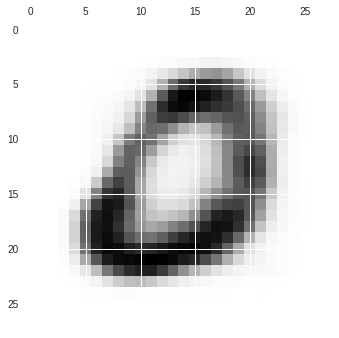

1.7401102017109042


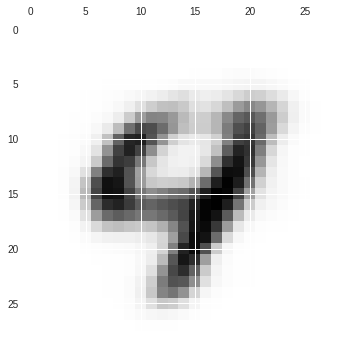

2.36548184270401


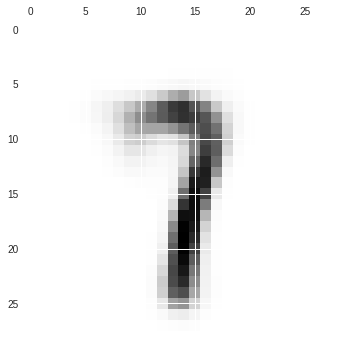

0.7532337545209308


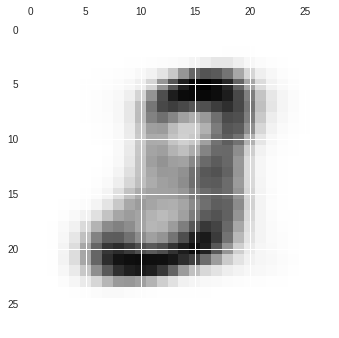

0.665789807323023


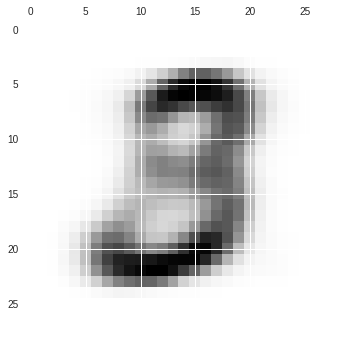

0.3736940402507696


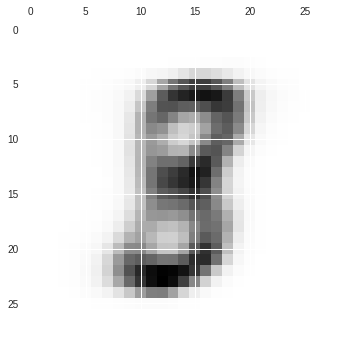

2.705177109247674


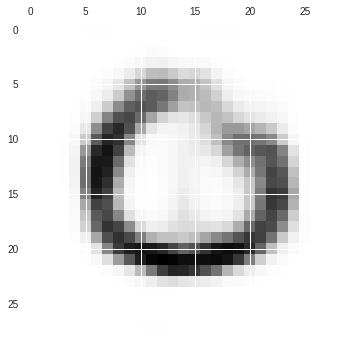

1.8710751104649679


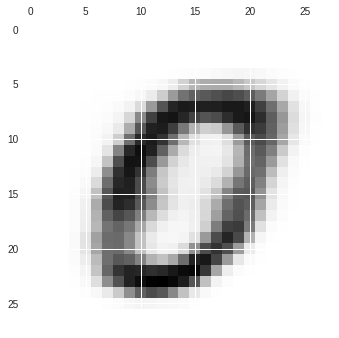

3.424725189353803


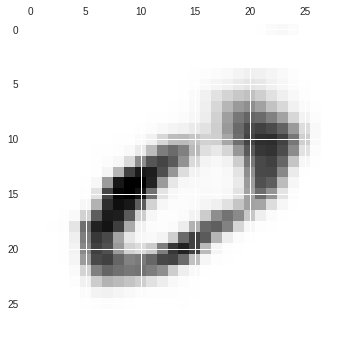

1.3319565324134097


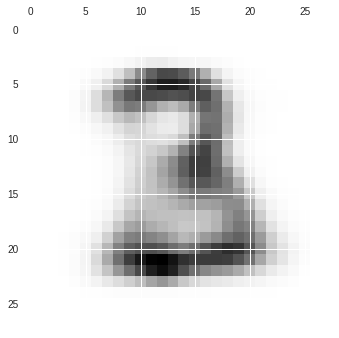

0.35686021392958334


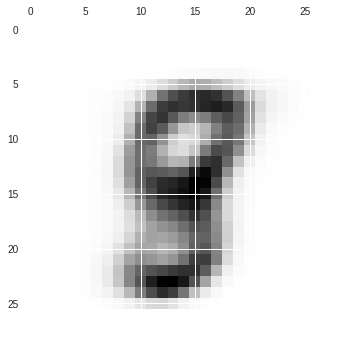

1.1186612995878695


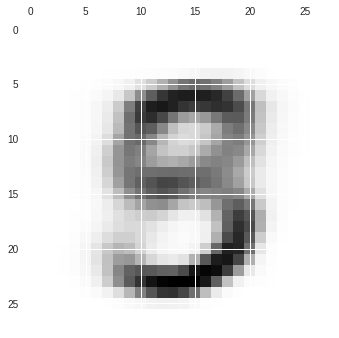

1.5464441609869817


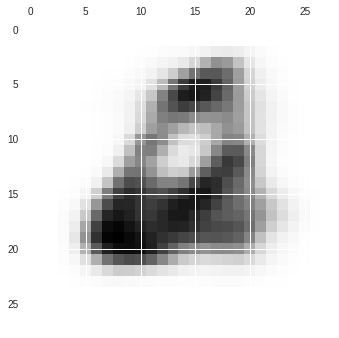

1.0550818980604764


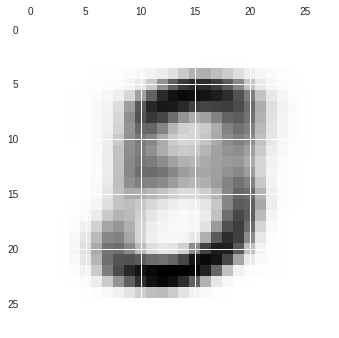

1.449078412535798


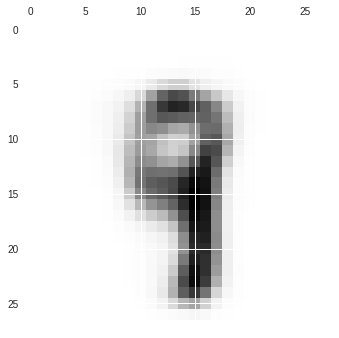

0.9593007316642815


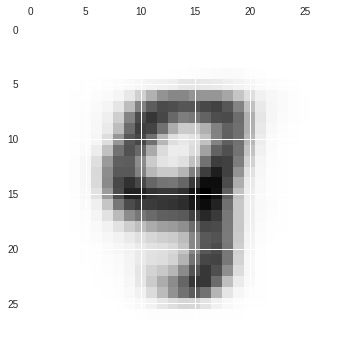

0.8725854633158074


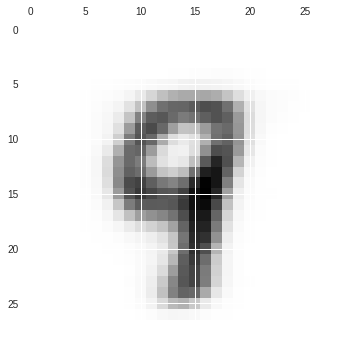

1.1666772678566764


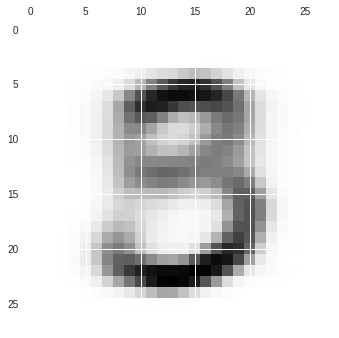

1.646053240269113


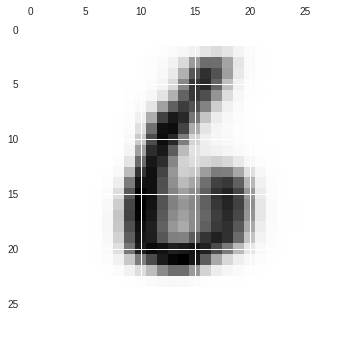

2.1906123793546484


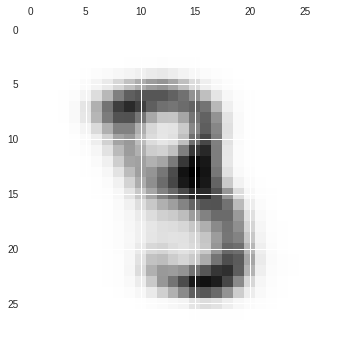

2.3309107869075727


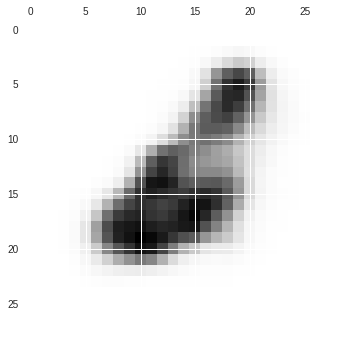

1.4289770733645044


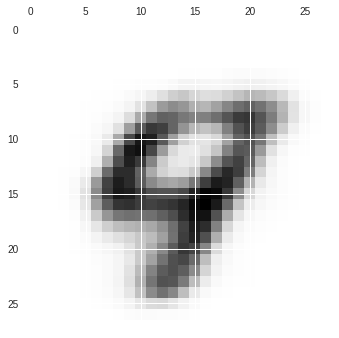

2.252258399238711


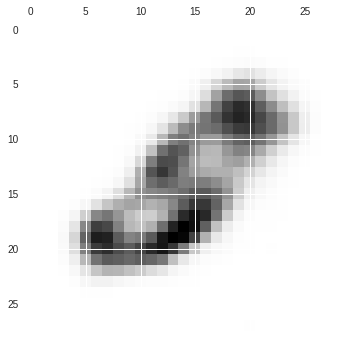

In [8]:
gauss=np.random.normal(0,1,size=(100,3))
gen = decoder([gauss])[0]
for g, r in zip(gen, gauss):
  print(np.linalg.norm(r))
  plt.matshow(g)
  plt.show()

In [0]:
import plotly.offline as py
import plotly.graph_objs as go
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-1.5.1.min.js?noext',
            },
          });
        </script>
        '''))

In [0]:
from keras.datasets import mnist

(_),(_,y_test)=mnist.load_data()

In [0]:
import pandas as pd

In [0]:
df=pd.concat([pd.DataFrame(coded),pd.Series(y_test,name="label")],axis=1)

In [45]:
configure_plotly_browser_state()

data=[]
for i in range(len(set(y_test))):
  trace=go.Scatter3d(
      x=df[df.label==i].iloc[:,0],
      y=df[df.label==i].iloc[:,1],
      z=df[df.label==i].iloc[:,2],
      mode="markers",
      marker=dict(
          size=1.5,
          opacity=0.5
      ),
      name=str(i)
  )
  data.append(trace)



layout = go.Layout(
    width=500,
    height=500,
)

fig = go.Figure(data=data)

py.iplot(fig)